In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))
from utilsforecast.preprocessing import fill_gaps
from tinyshift.stats import remove_leading_zeros, is_obsolete, generate_lag
from tinyshift.series import fourier_seasonality, trend_significance
from tinyshift.plot import stationarity_analysis, pami, residual_analysis, seasonal_decompose
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import MSTL
from statsforecast.models import SeasonalNaive, AutoETS
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, bias, cfe 
from tinyshift.series.stability import *
from tinyshift.series.interpolation import *

/home/heylucasleao/tinyshift/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)
df = fourier_seasonality(df, "ds", seasonality=["monthly"])
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)
obsolote_ids = obsolete_series[obsolete_series].index.tolist()
assert len(obsolote_ids) == 0, f"Obsolete series found: {obsolote_ids}"
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [3]:
df.isnull().sum()

unique_id      0
ds             0
y              0
monthly_sin    0
monthly_cos    0
dtype: int64

In [4]:
horizon = 12
#df["RANDOM_FEATURE_1"] = np.random.rand(len(df))
#df["RANDOM_FEATURE_2"] = np.random.normal(size=len(df))
train = df[:-horizon]
test = df[-horizon:]

In [5]:
def wape(df, models, id_col='unique_id', target_col='y'):
    """
    Calcula o WAPE (Weighted Absolute Percentage Error).
    'df' é o DataFrame de avaliação com 'unique_id', 'ds', 'y' (target) e colunas de modelo.
    """
    actual = df[target_col].to_numpy()

    results = {}
    for model_name in models:
        forecast = df[model_name].to_numpy()

        numerator = np.sum(np.abs(forecast - actual))
        denominator = np.sum(np.abs(actual))

        if denominator == 0:
            wape_score = 0.0 
        else:
            wape_score = numerator / denominator

        results[model_name] = wape_score

    return pd.DataFrame({
        'unique_id': df[id_col].unique(),
        'metric': 'wape',
        **results
    })

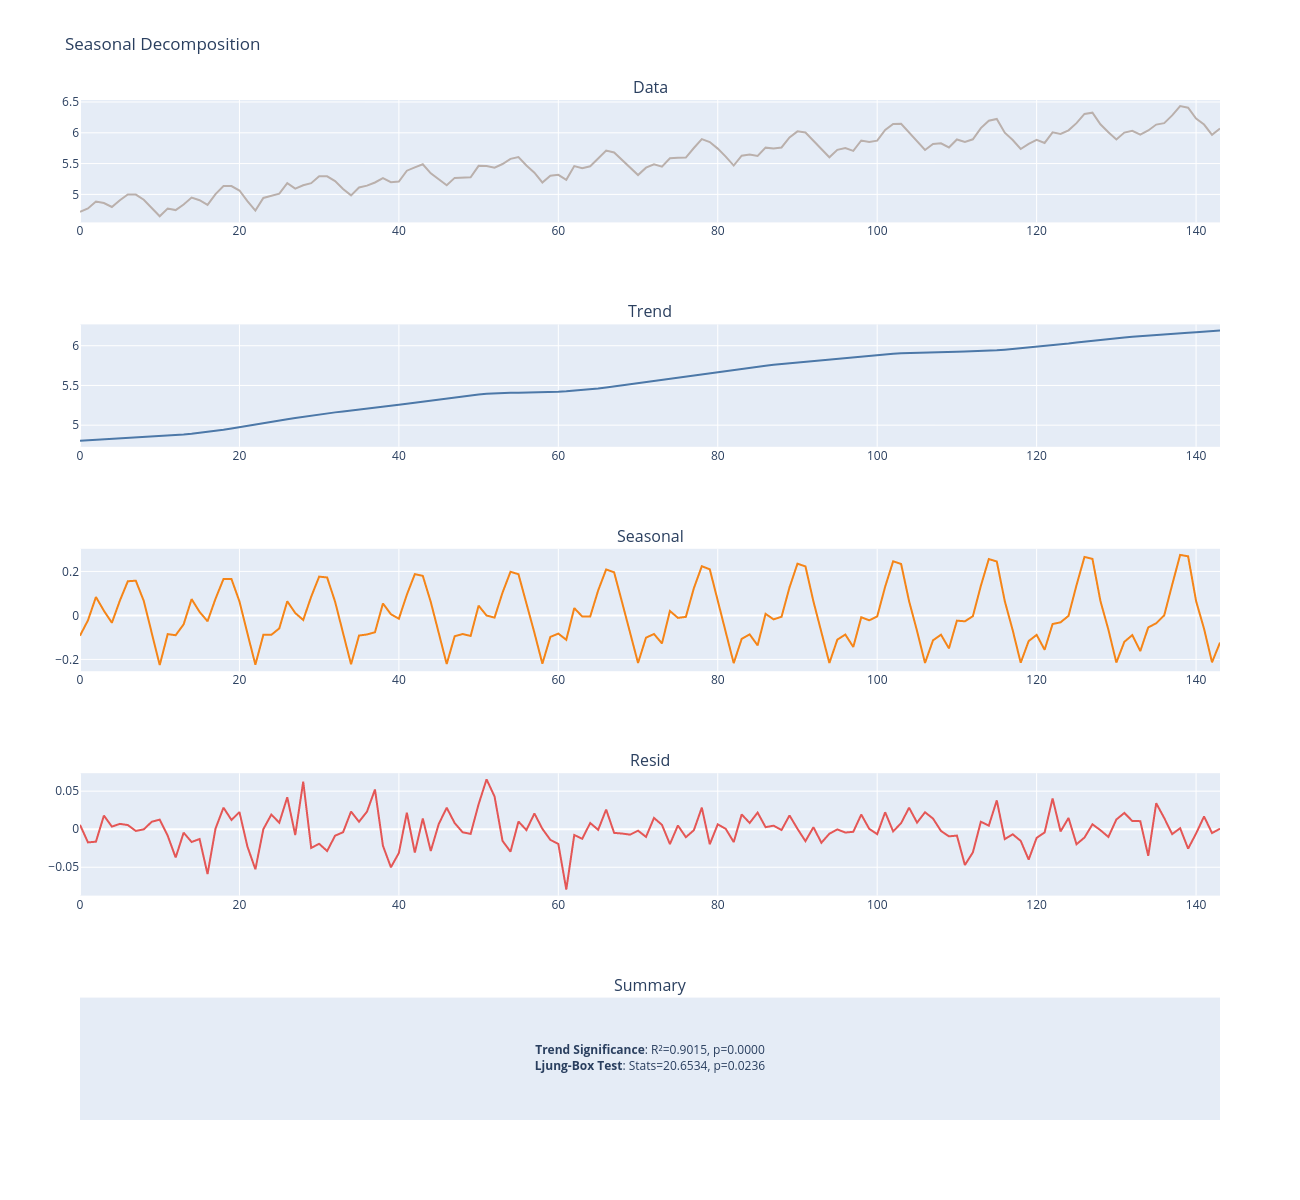

In [48]:
seasonal_decompose(np.log(df["y"]),periods=12,fig_type="png")

# Decomposition + ML

Linear Detrend + ML (Seasonality + Resiual)

In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from pandas.tseries.frequencies import to_offset

class LinearRegressionDetrendModels():
    def __init__(self):
        self.models = {} 
        self.last_time_index = {}
        self.freq = None
        self.last_index = {}
    
    def fit(self, df_train, freq, id_col="unique_id", time_col="ds", target_col="y"):
        forecasts = []

        for uid, group in df_train.groupby(id_col):
            self.last_time_index[uid] = group[time_col].max() 
            time_index = np.arange(len(group)).reshape(-1, 1)
            self.last_index[uid] = time_index[-1][0]
            trend_model = LinearRegression()
            trend_model.fit(time_index, group[target_col])
            self.models[uid] = trend_model
            self.freq = freq
            trend_forecast = trend_model.predict(time_index)
            uid_forecast = pd.DataFrame({
                id_col: uid,
                time_col: group[time_col],
                "trend": trend_forecast,
            })
            forecasts.append(uid_forecast)

        return pd.concat(forecasts).reset_index(drop=True)

    def predict(self, h, id_col="unique_id", time_col="ds"):
        
        forecasts = []
        
        for uid in self.models:

            future_dates = pd.date_range(
                start=self.last_time_index[uid] + to_offset(self.freq),
                periods=h,
                freq=self.freq
            )
            time_index = np.arange(self.last_index[uid] + 1, self.last_index[uid] + h + 1).reshape(-1, 1)
            trend_forecast = self.models[uid].predict(time_index)

            uid_forecast = pd.DataFrame({
                id_col: uid,
                time_col: future_dates,
                "trend": trend_forecast,
            })
            forecasts.append(uid_forecast)
                
        return pd.concat(forecasts).reset_index(drop=True)

In [8]:
detrend_linear = LinearRegressionDetrendModels()
train = train.copy()
train["log_y"] = np.log(train["y"])
trend = detrend_linear.fit(train, freq="MS", target_col="log_y")

In [9]:
train = pd.merge(train, trend, on=["unique_id", "ds"], how="inner")
train["y_log_detrend"] = train["log_y"] - train["trend"]
train["lag_1"] = generate_lag(train["y_log_detrend"], lag=1)
train["lag_12"] = generate_lag(train["lag_1"], lag=12)

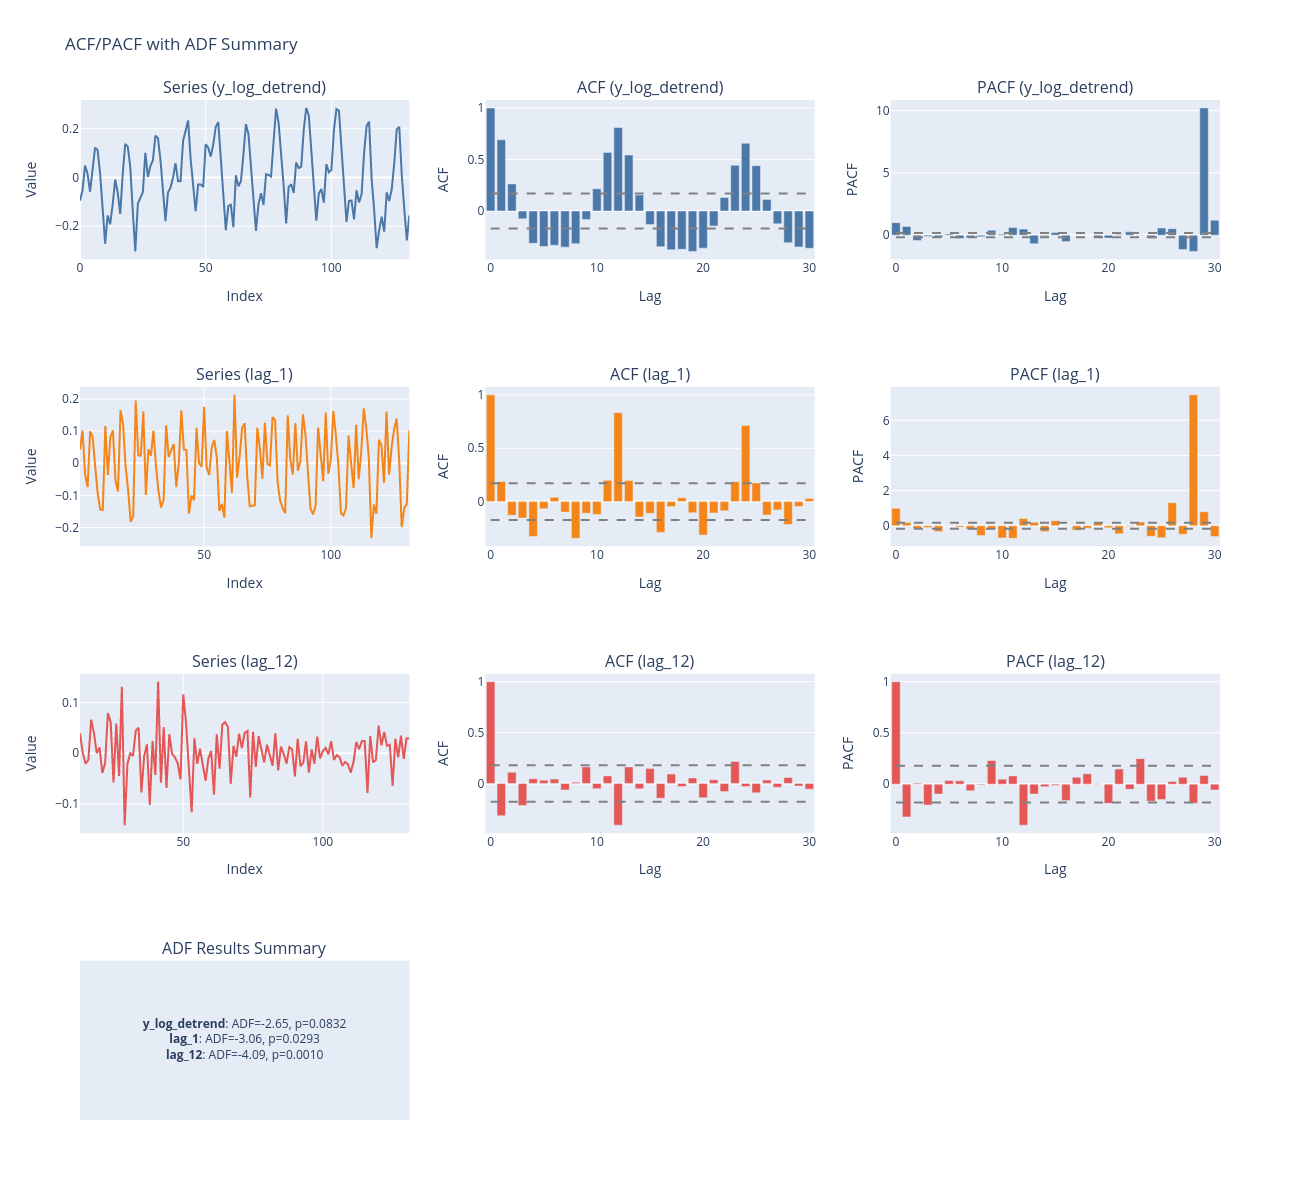

In [10]:
stationarity_analysis(train[["y_log_detrend", "lag_1", "lag_12"]], nlags=30, fig_type="png")

In [11]:
train.drop(columns=["lag_1", "lag_12"], inplace=True)

In [12]:
def compute_lgbm_params(N: int):
    max_depth = int(np.ceil(np.log2(N) - 1))
    subsample_freq = 1
    colsample_bytree = 0.7
    n_estimators = 1000
    reg_lambda = 0.2
    reg_alpha = 0.2
    metric = "mae"
    learning_rate = 0.05
    min_child_samples = max(20, int(np.cbrt(N)))
    n_jobs = -1
    random_state = 42

    return {
        "max_depth": int(max_depth),
        "subsample_freq": subsample_freq,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
        "metric": metric,
        "learning_rate": learning_rate,
        "num_leaves": 40,
        "min_child_samples": min_child_samples,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "objective": "regression_l2",
        "n_jobs": n_jobs,
        "random_state": random_state
    }

In [13]:
config = compute_lgbm_params(len(train))
models = [LGBMRegressor(**config, verbosity=-1)]
mf = MLForecast(
    models=models,
    freq='MS',
    lags=[2], #removi lag 1 e lag 12
    lag_transforms={
        1: [
        RollingMean(window_size=12), # Nível de longo prazo (12 meses)]},
        SeasonalRollingMean(window_size=2, season_length=12)
        ],
        6: [ExpandingMean()], # Média acumulada (longo prazo)
    },
    target_transforms=[Differences([1, 12])],
)
mf.fit(train[["unique_id", "ds", "y_log_detrend"]], static_features=[], target_col="y_log_detrend")

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag2', 'rolling_mean_lag1_window_size12', 'seasonal_rolling_mean_lag1_season_length12_window_size2', 'expanding_mean_lag6'], date_features=[], num_threads=1)

log(Y) = log(S+R) + log(T)

In [14]:
forecasting_trend = detrend_linear.predict(h=12)
result = mf.predict(h=12)

In [15]:
result

,unique_id,ds,LGBMRegressor
0,1,1960-01-01,-0.088699
1,1,1960-02-01,-0.162448
2,1,1960-03-01,0.007667
3,1,1960-04-01,-0.040382
4,1,1960-05-01,0.017031
5,1,1960-06-01,0.120301
6,1,1960-07-01,0.261122
7,1,1960-08-01,0.269191
8,1,1960-09-01,0.072443
9,1,1960-10-01,-0.083177


In [16]:
detrend_linear.predict(h=12)

,unique_id,ds,trend
0,1,1960-01-01,6.170168
1,1,1960-02-01,6.180448
2,1,1960-03-01,6.190728
3,1,1960-04-01,6.201008
4,1,1960-05-01,6.211288
5,1,1960-06-01,6.221569
6,1,1960-07-01,6.231849
7,1,1960-08-01,6.242129
8,1,1960-09-01,6.252409
9,1,1960-10-01,6.262689


In [17]:
assert len(result) == len(test), "O número de previsões não corresponde ao número de observações de teste."

In [18]:
assert len(result) == len(forecasting_trend), "O número de previsões não corresponde ao número de observações de teste."

In [19]:
result = pd.merge(result,forecasting_trend, on=["unique_id", "ds"], how="inner")
result["Reconstructed"] = result["LGBMRegressor"] + result["trend"]

Y = exp(log(Y)) -> (Y = (S * R) * T)

In [20]:
result["y_pred"] = np.exp(result["Reconstructed"])
result["y"] = test["y"].values

In [21]:
metrics = [
    mae,
    rmse,
    bias,
    cfe,
]

In [22]:
evaluate(result, 
         metrics=metrics, 
         models=["y_pred"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,y_pred
0,1,mae,37.641955
1,1,rmse,41.614743
2,1,bias,37.641955
3,1,cfe,451.703454


In [23]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LGBMRegressor"].feature_names_in_,
    'importance': mf.models_["LGBMRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [24]:
feature_importance

,feature,importance
0,lag2,424
1,seasonal_rolling_mean_lag1_season_length12_win...,107
2,rolling_mean_lag1_window_size12,88
3,expanding_mean_lag6,78


In [25]:
test = test.copy()
test["residual_reconstructed"] = result["y"].values - result["y_pred"].values

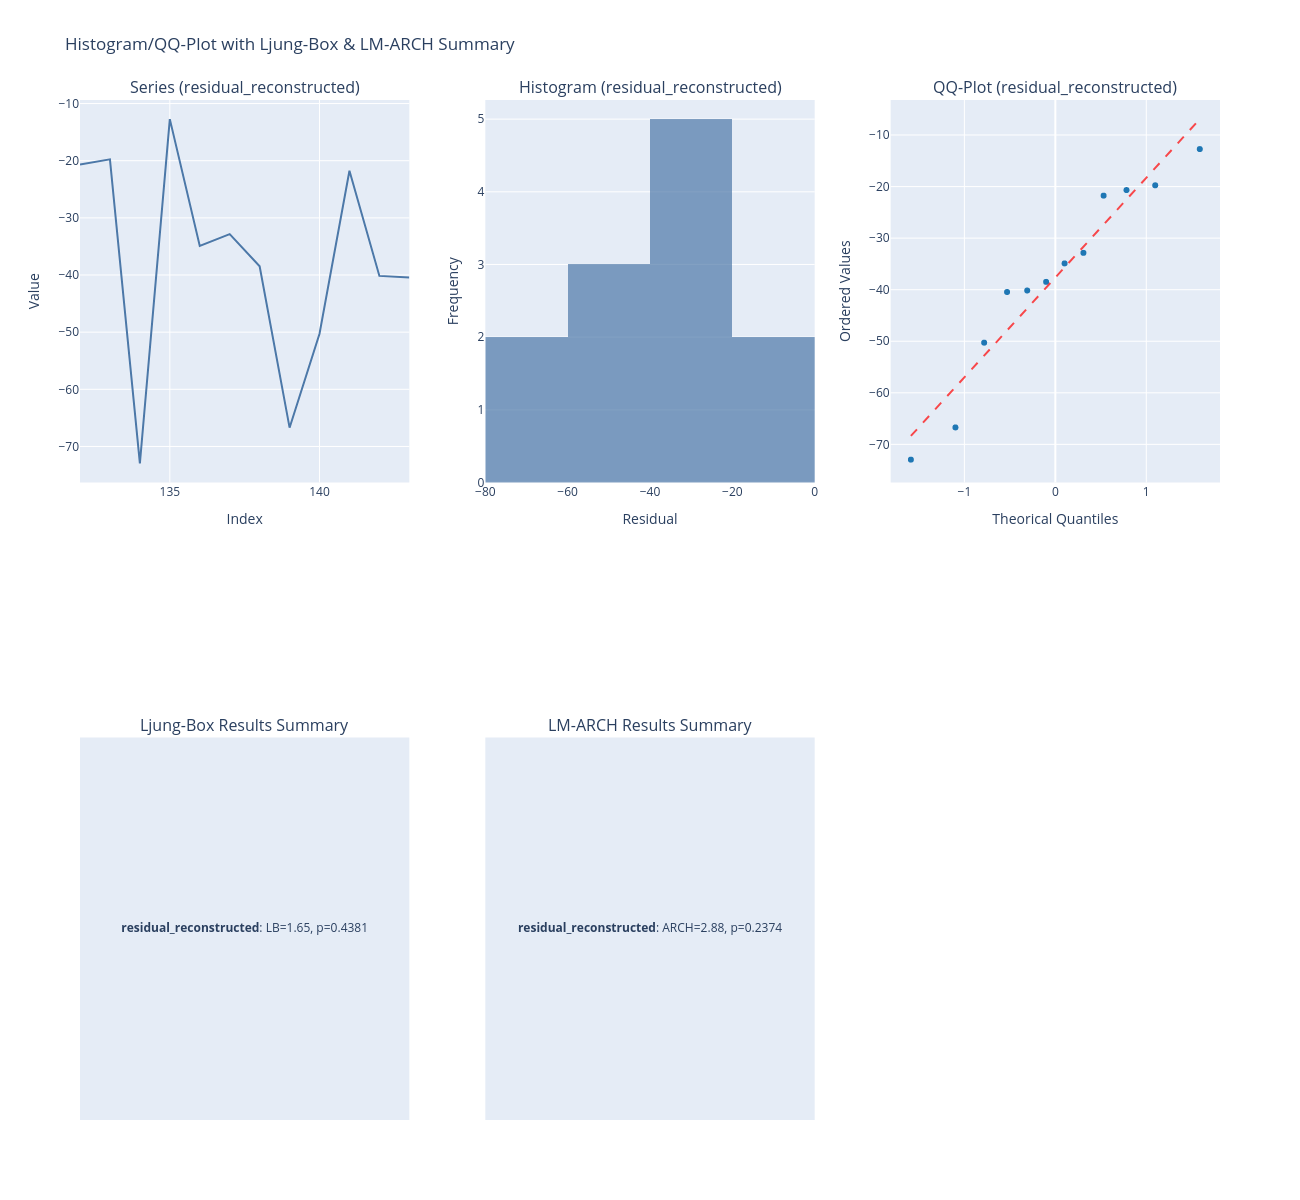

In [26]:
residual_analysis(test[["residual_reconstructed"]], nlags=30, fig_type="png")

## MSTL + ML

In [27]:
def convert_to_dataframe(result: MSTL) -> pd.Series:
        """
        Reconstructs the original time series from its MSTL decomposition components.

        Parameters
        ----------
        result : MSTL
            Fitted MSTL object containing the decomposition components.

        Returns
        -------
        pandas.Series
            Reconstructed time series obtained by summing the trend, seasonal, and residual components.
        """
        df = pd.DataFrame()
        df["data"] = result.observed
        df["trend"] = result.trend
        if isinstance(result.seasonal, pd.Series):
            df["seasonal"] = result.seasonal
        else:
            for seasonal_col in result.seasonal.columns:
                df[seasonal_col] = result.seasonal[seasonal_col]
        df["resid"] = result.resid

        return df

In [28]:
mstl = MSTL(train["y"], periods=12).fit()
decomp = convert_to_dataframe(mstl)

In [ ]:
season_length = 12
seasonal = SeasonalNaive(season_length=season_length)
trend = AutoETS(season_length=season_length, model="MMN") # Seasonality already removed, so 'S' is N!
seasonal.fit(decomp["seasonal"])
trend.fit(decomp["trend"])

AutoETS

In [30]:
trend.model_.get("method")

'ETS(M,Md,N)'

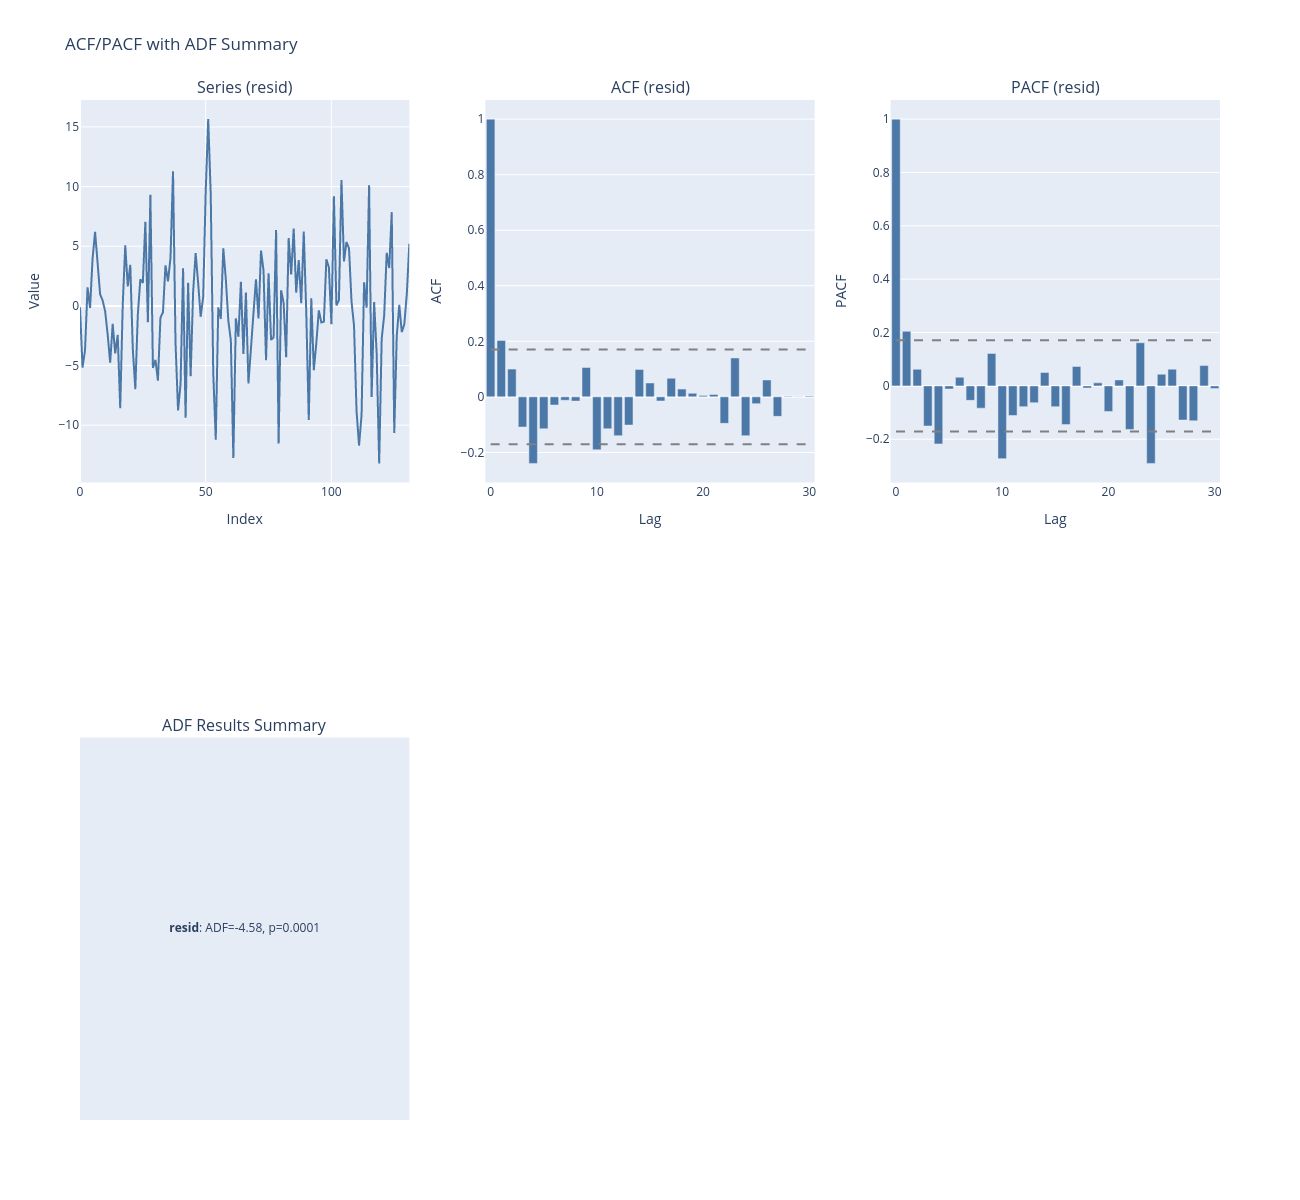

In [31]:
stationarity_analysis(decomp["resid"], nlags=30, fig_type="png")

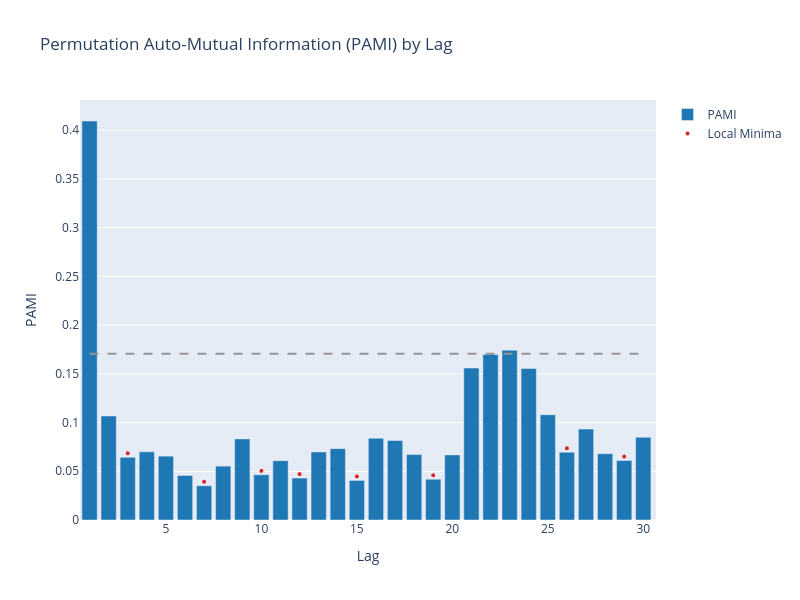

In [32]:
pami(decomp["resid"], nlags=30, fig_type="png", m=3, normalize=True)

In [33]:
decomp["ds"] = train["ds"]
decomp["unique_id"] = train["unique_id"]

In [34]:
mf = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 3],
)
mf.fit(decomp[["resid", "ds", "unique_id"]], static_features=[], target_col="resid")

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag3'], date_features=[], num_threads=1)

In [35]:
result = mf.predict(h=12)
result["seasonal_forecast"] = seasonal.predict(h=12).get("mean")
result["trend_forecast"] = trend.predict(h=12).get("mean")
result["reconstructed"] = result["LGBMRegressor"].values + result["seasonal_forecast"].values + result["trend_forecast"].values
result["y"] = test["y"].values

In [36]:
evaluate(result, 
         metrics=metrics, 
         models=["reconstructed"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,reconstructed
0,1,mae,11.333683
1,1,rmse,14.521539
2,1,bias,3.813138
3,1,cfe,45.757661


In [37]:
result["residual_reconstructed"] = result["y"].values - result["reconstructed"].values

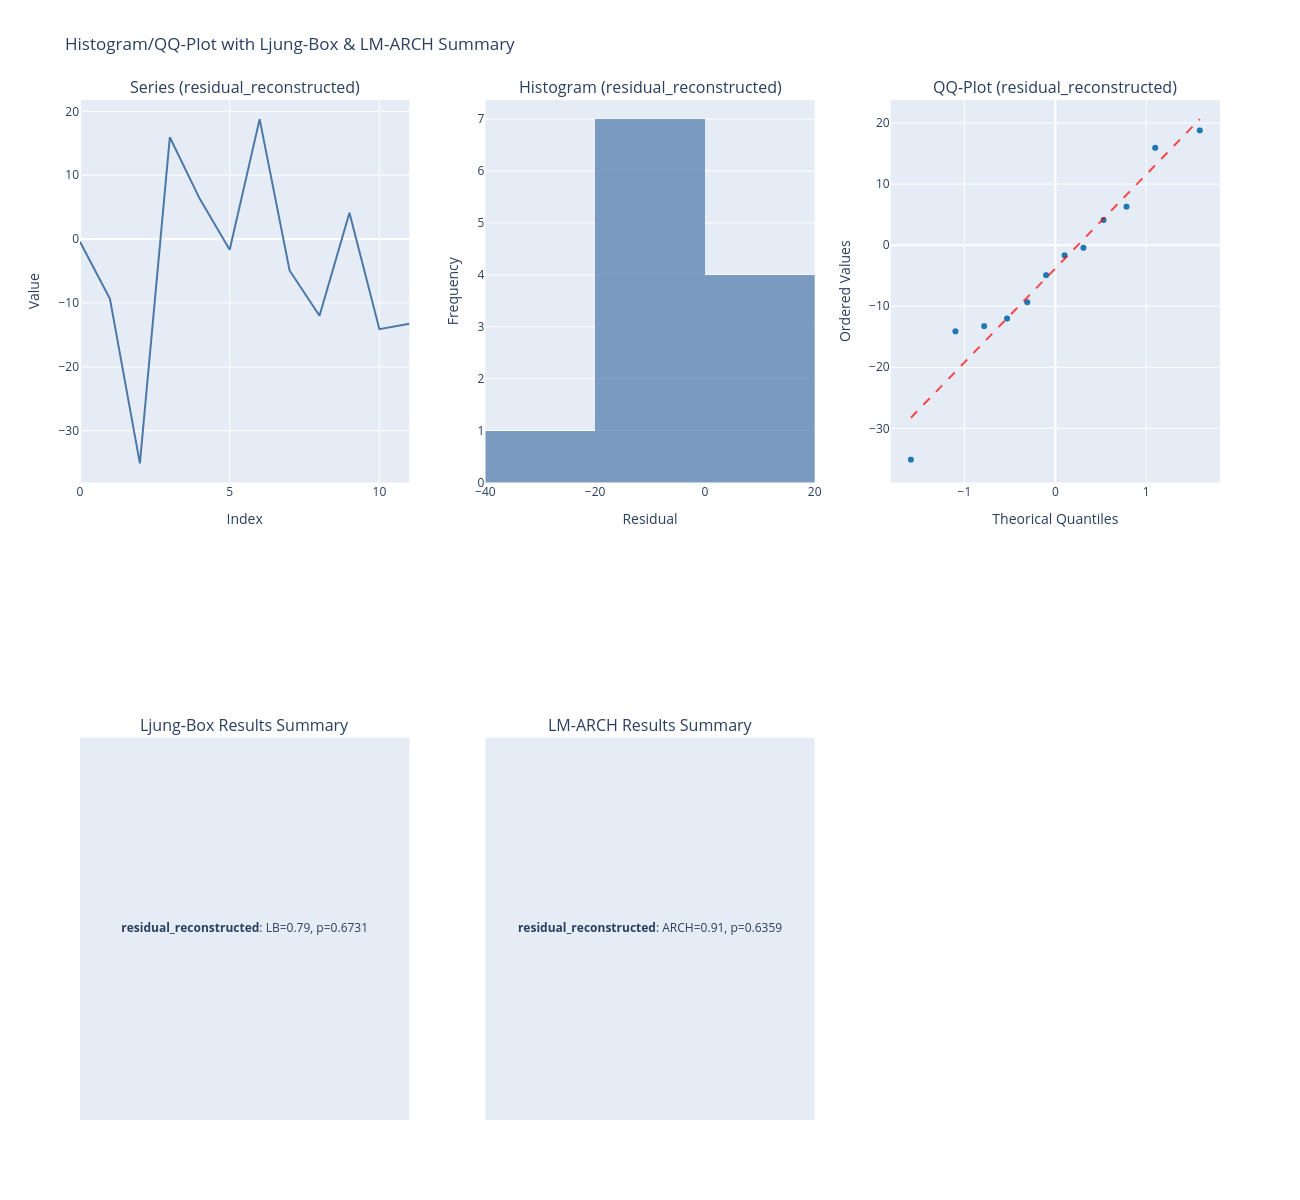

In [38]:
residual_analysis(result["residual_reconstructed"], nlags=30, fig_type="png")

In [39]:
result = mf.predict(h=12)
result["seasonal_forecast"] = seasonal.predict(h=12).get("mean")
result["trend_forecast"] = trend.predict(h=12).get("mean")
result["Reconstructed"] = result["LGBMRegressor"] + result["seasonal_forecast"] + result["trend_forecast"]
result["y_pred"] = result["Reconstructed"]

In [40]:
seasonality_val = 12
rmssc_h_result = rmssch(train["y"], result["y_pred"], seasonality_val)
mac_h_result = mach(result["y_pred"])
print(f"MAC(H) (Horizontal Stability): {mac_h_result:.6f}")
print(f"RMSSC(H) (Horizontal Stability - Squared): {rmssc_h_result:.6f}")

MAC(H) (Horizontal Stability): 44.882345
RMSSC(H) (Horizontal Stability - Squared): 1.510142


## Original

In [41]:
rmssc_h_result = rmssch(train["y"], result["y_pred"], seasonality_val)
mac_h_result = mach(result["y_pred"])
print(f"MAC(H) (Horizontal Stability): {mac_h_result:.6f}")
print(f"RMSSC(H) (Horizontal Stability - Squared): {rmssc_h_result:.6f}")

MAC(H) (Horizontal Stability): 44.882345
RMSSC(H) (Horizontal Stability - Squared): 1.510142


## Horizontal Partial Interpolation

In [42]:
result["y_pred_pi"] = hpi(result["y_pred"] , 0.4)
#result["y_pred_pi"] = hpi(result["LGBMRegressor"] , 0.8)
#result["y_pred_pi"] = result["y_pred_pi"] + result["seasonal_forecast"] + result["trend_forecast"]
rmssc_h_result = rmssch(train["y"], result["y_pred_pi"], seasonality_val)
mac_h_result = mach(result["y_pred_pi"])
print(f"MAC(H) (Horizontal Stability): {mac_h_result:.6f}")
print(f"RMSSC(H) (Horizontal Stability - Squared): {rmssc_h_result:.6f}")

MAC(H) (Horizontal Stability): 36.099838
RMSSC(H) (Horizontal Stability - Squared): 1.256423


## Horizontal Full Interpolation

In [43]:
result["y_pred_fi"] = hfi(result["y_pred"] , 0.4)
#result["y_pred_fi"] = hfi(result["LGBMRegressor"] , 0.8)
#result["y_pred_fi"] = result["y_pred_fi"] + result["seasonal_forecast"] + result["trend_forecast"]
rmssc_h_result = rmssch(train["y"], result["y_pred_fi"], seasonality_val)
mac_h_result = mach(result["y_pred_fi"])
print(f"MAC(H) (Horizontal Stability): {mac_h_result:.6f}")
print(f"RMSSC(H) (Horizontal Stability - Squared): {rmssc_h_result:.6f}")

MAC(H) (Horizontal Stability): 31.852026
RMSSC(H) (Horizontal Stability - Squared): 1.090923


## Results

In [44]:
result["y"] = test["y"].values

In [45]:
evaluate(result, 
         metrics=metrics, 
         models=["y_pred"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,y_pred
0,1,mae,11.333683
1,1,rmse,14.521539
2,1,bias,3.813138
3,1,cfe,45.757661


In [46]:
evaluate(result, 
         metrics=metrics, 
         models=["y_pred_pi"], 
         id_col="unique_id",
         train_df=train, 
         time_col="ds", 
         target_col="y")

,unique_id,metric,y_pred_pi
0,1,mae,19.915562
1,1,rmse,25.210961
2,1,bias,2.885382
3,1,cfe,34.624586


In [47]:
evaluate(result, 
         metrics=metrics, 
         models=["y_pred_fi"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,y_pred_fi
0,1,mae,25.531306
1,1,rmse,30.369094
2,1,bias,2.385413
3,1,cfe,28.624951
